In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Loading Data Set
Three sets are created: training, validation, and test. 
- Labels are generated based on the folder structure. Class name must correspond to the subfolder name.
- Loading in batches, of size 32, to reduce memory usage.
- Label mode is set to categorical, which means that the labels are encoded as a categorical vector.

Bilinear interploation is set to default. This specify the method used in the resizing procedure. By default aspect ratio is not perserved, i.e., the ratio between image width and height.

One hot encoding is utilized when label mode is set to categorical.


The image load documentation is available [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) and an example is available [here](https://keras.io/api/data_loading/image/).

In [6]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='../../baseline_training_set/train/',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=32,
    image_size=(256, 256))
validation_ds = keras.utils.image_dataset_from_directory(
    directory='../../baseline_training_set/validation/',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=32,
    image_size=(256, 256))
test_ds = keras.utils.image_dataset_from_directory(
    directory='../../baseline_training_set/test/',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=32,
    image_size=(256, 256))

Found 22320 files belonging to 15 classes.


2023-01-23 12:21:32.889221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-23 12:21:32.889464: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-23 12:21:32.889515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brothel420): /proc/driver/nvidia/version does not exist
2023-01-23 12:21:32.891076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2790 files belonging to 15 classes.
Found 2790 files belonging to 15 classes.


# Visualizing the Data

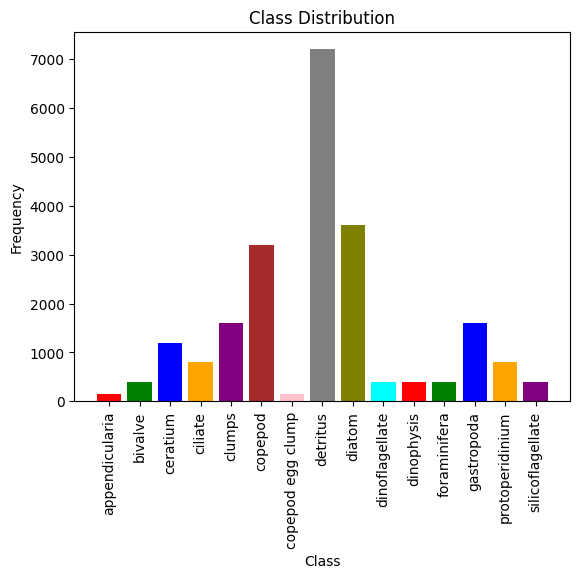

In [15]:
# histogram of class distribution in the data set
# remove underscores from class names
class_names = train_ds.class_names
class_names = [name.replace('_', ' ') for name in class_names]
class_counts = [0]*len(class_names)

# get the number of samples in each class
for images, labels in train_ds:
    for i in range(len(labels)):
        class_counts[np.argmax(labels[i])] += 1
# plot the histogram
plt.bar(class_names, class_counts, color=['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


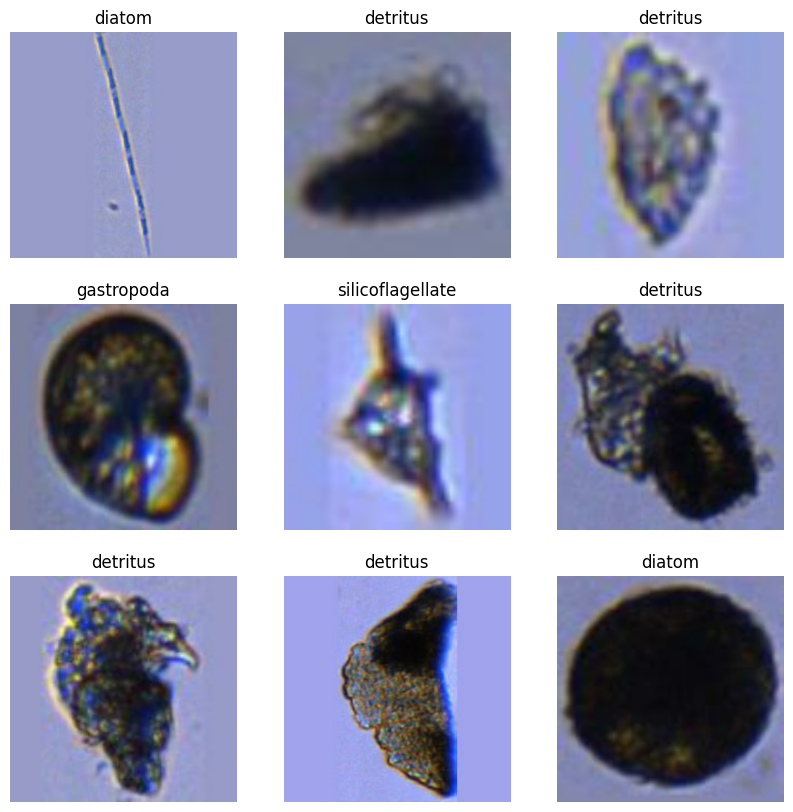

In [16]:
# plot some images from the data set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Model Creation

In [20]:
def create_base_model():
    return tf.keras.applications.ResNet50(
        include_top=False, # do not include the classification layer
        weights="imagenet", # load pre-trained weights
        input_shape=(256, 256, 3) # specify input shape
    )

In [21]:
def freeze_base_model(model):
    # freeze the base model
    model.trainable = False

    return model

In [22]:
def create_model():
    # create a base model
    base_model = create_base_model()
    # freeze the base model
    base_model = freeze_base_model(base_model)
    
    # it might be worth trying this architecture: https://datagen.tech/guides/computer-vision/resnet-50/

    # create a new model
    inputs = keras.Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, x)

    return model

In [26]:
model = create_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_______________________________________